<h1 id="tocheading">Model and Tools</h1>
<div id="toc"></div>

Here is the code for all functions and classes used in simulations and analysis of results.

In [4]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
// https://github.com/kmahelona/ipython_notebook_goodies          ...interactive table of contents

<IPython.core.display.Javascript object>

In [ ]:
# command line code for making JUPYTER code cells collapsible
# pip install nbextension-cellfolding
# jupyter nbextension install --py cellfolding --user
# jupyter nbextension enable --py cellfolding --user 

Generall notes: 
* random vs np.random:
* random is quicker with small lists, numpy with long ones (practically for permutations or sampling >35 agents, done only few times in a period)
* transformation between lists and np arrays takes considerable time


* pd.DataFrame:
* operations of type column*+column are quick, especially with >1000 agents, but every operation counts on its own so it is useless for complicated functions + problem of referencing back to agents


* stock-flow consistency might be distrubed due to rounding of currency exchanges in the scenario of 1 global bank (to check)

In [2]:
import random
import numpy as np
from pandas import DataFrame as DF
import matplotlib.pyplot as plt

parameters

In [5]:
# parameters
# model
no_countries = 1
ns = [5000]    # no HSHs
ms = [550]     # no firms
global_bank = False      # just one bank for the whole world?

# HSHs
wage_resist = [12]*no_countries  # wage resistance in unemployment; 12 in baseline, 8 in alternative
wage_flex = [0.05]*no_countries  # wage flexibility;                0.05 in baseline, 0.08 or 0.25 in alternative
prop_to_save_O = 0.15        # optimistic saving target
prop_to_save_P = 0.2         # pessimistic saving target
cons_of_excess_savings = 0.5 # rate of cons. of excess savings

if no_countries == 2:
    providers = 15                 # market selection - no of firms considered by each hsh
elif no_countries == 6:
    providers = 30                
else:
    providers = 10

# firms
K = 10                # no of machines
productivity = 100    # machine productivity

production_time = 8           # length of production
inv_normal = 2                # periods of full prod. for targeted inventories
price_flex = 0.05             # adjustment parameter
#d_p = random.randrange(1,4)  # price rigidity;  for a firm, drawn after each price change 
targeted_vacancies = 0.03     # targeted vacancies 
#d_w_e = random.randrange(6,18) # length of employment constracts - drawn for each new contract separately
mu_F = 0.5                    # goods to be sold
capital_normal_ratio = 0.2    # optimisstic targeted net wealth
capital_high_ratio = 0.5      # pessimistic targeted net wealth
sales_normal_ratio = 0.83     # targeted sales - to use for sentiment; in paper it is 0.85
#t_f = random.randrange(12,36) # regeneration time after bankruptcy; drawn anew for each bankruptcy
in_T = inv_normal*K*productivity # targeted inventories

#util_rate = random.randrange(50,100)   # initial targeted utilization rate of machinery for a firm; drawn for each firm at creation
util_flex = 10                # flexibility (adjustment) of utilization rate

wage_flex_up = 0.06       # upward wage flexibility  
wage_flex_down = 0.09     # downward wage flexibility

# bank
r = 0.05           # normal interest rate
r_ = 0.1           # premium interest rate
normal_length = 12      # normal credit length
extended_length = 12    # extended credit length
kappa_B = 0.085         # targeted capital;   in the paper it is 0.1

# opinion
p = 0.7     # animal spirits
h = 3       # size of neighbourhood

In [6]:
def parameters():
    """Returns dictionary with the current parameter values."""
    
    return {"no_countries": "number of countries = " + str(no_countries),
              "ns": "number of HSHs = " + str(ns),                               "ms": "number of firms = " + str(ms),
                            
              "wage_resist": "hsh - wage resistance in unemployment = " + str(wage_resist),  "wage_flex": "hsh - wage flexibility = " + str(wage_flex),
              "prop_to_save_O": "hsh - optimistic saving target = " + str(prop_to_save_O), "prop_to_save_P": "hsh - pessimistic saving target = " + str(prop_to_save_P),
              "cons_of_excess_savings": "hsh - rate of cons. of excess savings = " + str(cons_of_excess_savings),    "providers": "hsh - size of market selection = " + str(providers),
              
              "K": "f - number of machines = " + str(K),                         "productivity": "f - machine productivity = " + str(productivity),   
              "production_time": "f - length of production = " +str(production_time),                    "inv_normal": "f - periods of full prod. for targeted inventories = " + str(inv_normal),
              "price_flex": "f - adjustment parameter = " + str(price_flex),       "targeted_vacancies": "f - targeted rate of vacancies = " + str(targeted_vacancies),            
              "mu_F": "f - portion of goods to be sold = " + str(mu_F),          "capital_normal_ratio": "f - optimisstic targeted net wealth = " + str(capital_normal_ratio),
              "capital_high_ratio": "f - pessimistic targeted net wealth = " + str(capital_high_ratio), "sales_normal_ratio": "f - targeted sales = " + str(sales_normal_ratio),
              "in_T": "f - targeted inventories = inv_normal*K*productivity = " + str(in_T), "util_flex": "f - flexibility of utilization rate = " + str(util_flex),
              "wage_flex_up": "f - upward wage flexibility = " + str(wage_flex_up), "wage_flex_down": "f - downward wage flexibility = " + str(wage_flex_down),
              
              "r": "B - standard interest rate = " + str(r),                     "r_": "B - premium interest rate = " + str(r_),
              "normal_length": "B - credit length of repayment = " + str(normal_length), "extended_length": "B - extended length of repayment = " + str(extended_length),
              "kappa_B": "B - targeted capital = " + str(kappa_B),
              
              "p": "opinion model - strength of animal spirits = " + str(p),     "h": "opinion model - size of neighbourhood = " + str(h)
               }
    

In [7]:
# international trade parameters
trade_sensitivity = 0.1              # sensitivity in exchange factors updating    ## gamma
normal_variance = 0.002

trade_costs = np.array([[0.05]*no_countries]*no_countries)                         ## tau
np.fill_diagonal(trade_costs, [0]*no_countries)                              ## keep as np array 

trade_quotas = np.array([[1]*no_countries]*no_countries)                                  
np.fill_diagonal(trade_quotas, [1]*no_countries) 
trade_quotas = [list(country) for country in trade_quotas]                   ## quicker to have it as list

if no_countries == 2:
    providers = 15                 # market selection - no of firms considered by each hsh
elif no_countries == 6:
    providers = 30                
else:
    providers = 10

# Households

HSH class

In [10]:
class HSH:
    """Individual household."""
        
    def __init__(self, country, ID):
        # parameters       pouzit ako globalnu (setri pamat) alebo ako attribute (asi setri cas)?
        self.wage_resist = wage_resist               # length of wage resistance in unemployment
        self.wage_flex = wage_flex                   # wage adjustment
        self.optimist = prop_to_save_O               # optimistic saving target
        self.pessimist = prop_to_save_P              # pessimistic saving target
        self.excess_cons = cons_of_excess_savings    # rate of cons. of excess savings
        self.neighborhood = h            # size of sentiment-influencing neighborhood
        self.spirits = p                 # strength of animal spirits
        
        # individual hsh-specific attributes
        self.type = "h"    #  bank, firm, hsh
        self.country = country
        self.ID_no = int(ID) 
        self.ID = str(self.country) + "_" + "h" + "_" + str(ID)
        
        # initial values, variables
        self.rec_div = 0       # no of dividends this hsh receives                               ## not needed
        # wage taking
        self.res_wage = 0             # reservation wage                                  
        self.wage = 0                 # actual wage, determined on job market
        self.months_u = 0             # months since unemployed        
        self.employed = False         # currently employed?
        self.worked = True            # did work during the previous period? initially true due to its use in sentiment updating
        self.vol_unemployed = False   # if refused the best wage offer
        
        # sentiment
        self.sentiment = random.choice([True, False])   # optimistic if True
        self.old_sentiment = self.sentiment             # needed if influencing other households' sentiments
        self.saving_fraction =  self.optimist if self.sentiment else self.pessimist
        
        # consumption
        self.yearly_income = []     # list of incomes in past 12 months 
        self.income = 0             # current period income
        self.avg_income = 0         # 12 month average income                                 ## not needed as attribute
        self.savings_T = 0          # targeted savings
        self.cons_T = 0             # targeted consumption
        self.budget = 0             # actual budget as minimum between targeted consumption and cash on hand 
        self.cons = 0               # volume of current consumption
        self.cons_value = 0         # value of current consumption
        self.forced_savings = self.budget - self.cons_value # unused budget
        
        # archive of data - might be used for chosen households
        self.archive = ["archive of " + self.ID] 
        
    def create_account(self):
        """At initialization, creates a bank account."""
        self.account = Account(self.country, self)     # note - must be seperate from __init__ because we need to have bank 
                                            # for it, but we also need households for initialization of banks (ownership)
    
    
    def sentiment_update(self):
        """Updates households sentiment and saving behaviour. 
        As timing technicality, refreshes income, wage and voluntary unemployment."""
        self.income = 0                      # refreshing
        self.vol_unemployed = False          # refreshing
        if not self.employed:                # refreshing, here in order to avoid inconsistencies during bankruptcies
            self.wage = 0
        
        influenced = random.random()
##        # version of immidiate dependency on job status
##        if not self.worked:            # unemployed in the previous period?   then not depended on animal spirits
        # version from JAMEL code - dependednt on work from 2 periods before, everyone pessimistic in the second period
        if self.months_u > 0:            # unemployed in the second-to-last period?   then not depended on animal spirits
            self.sentiment = False     # false for pessimist
            self.saving_fraction = self.pessimist
        else:
            if influenced > self.spirits:    # does not rely on others
                self.sentiment = True        # true for optimist
                self.saving_fraction = self.optimist
            else:                            # relies on others
##                neighbors = np.random.choice(np.delete(HSHs[self.country],self.ID_no), self.neighborhood, replace = False)
                global HSHs
                neighbors = random.sample(HSHs[self.country], k=self.neighborhood) # can actually contain intself
                votes = sum([hsh.old_sentiment for hsh in neighbors])  # use old sentiment of neighbors
                if votes > self.neighborhood/2:
                    self.sentiment = True
                    self.saving_fraction = self.optimist
                else:
                    self.sentiment = False
                    self.saving_fraction = self.pessimist
        self.worked = False            # refreshing
        
        
    def res_wage_update(self):
        """Updates reservation wage, count of unemployed months. Part of labor market."""
        if self.employed:
            self.res_wage = self.wage
            self.months_u = 0
        else:
            if self.months_u == 0:
                self.months_u = random.random()          # so there is some small chance of adjustment, also used in sentiment updating
            else:
                self.months_u += 1
            alpha, beta = random.random(), random.random()
            if alpha*self.wage_resist < self.months_u:   # not resistant to lowering of reservation wage?
                self.res_wage *= 1 - beta*self.wage_flex
        
       
    def consumption_update(self):                                 
        """Updates targeted consumption. As timing technicality, updates old sentiment."""
        self.cons, self.cons_value = 0, 0               # refreshing
        self.yearly_income.append(self.income)            # updating
        self.yearly_income = self.yearly_income[-12:]
        self.avg_income = sum(self.yearly_income)/len(self.yearly_income)                    ## not needed as attribute
        
        self.savings_T = int(12*self.avg_income*self.saving_fraction)     # truncated
        
        savings = int(self.account.deposit - self.avg_income)             # truncated
        if savings < self.savings_T:
            self.cons_T = int((1 - self.saving_fraction)*self.avg_income) # truncated
        else:
            self.cons_T = int(self.avg_income + self.excess_cons*(savings - self.savings_T)) # truncated
        self.budget = min(self.account.deposit, self.cons_T)
        
        self.old_sentiment = self.sentiment
        
    def purchase(self, volume, value):
        """Purchase and consumption of goods. Part of goods market."""
        self.account.deposit -= value
        self.cons += volume
        self.cons_value += value
    
    
    def archiving(self, *attributes):
        """Adds to archive chosen attribute values."""
        global period
        if not period % 5:                       # ie. if period % 5 == 0
            self.archive.append(attributes)
        new_report = ["period: " + str(period)]
        for attr in attributes:
            sub_attributes = attr.split(".")
            obj = self
            for sub_attr in sub_attributes:      # consider eg. account.deposit
                obj = getattr(obj, sub_attr)
            new_report.append(obj)   
        self.archive.append(new_report)
    

# Firms

Machine class

In [11]:
class Machine:
    """Individual machine. Listed within a firm. Keeps track of its production process progress and value."""
   
    def __init__(self, firm, ID):
        self.productivity = productivity   # amount of volume added in 1 update
        self.prod_length = production_time             # length of production
    
        self.ID = ID         # firmID + "_m" + NUMBER
        self.firm = firm
        self.progress = 0    # how far is it in production process?
        self.value = 0       # wages spend on working this machine during current production process
    
    def update(self, wage):
        """Updates production process, add inventories when the process finishes."""
        self.progress += 1
        self.value += wage
        if self.progress >= self.prod_length:
            self.firm.new_prod += self.productivity*self.progress   # final volume is 8*productivity
            self.firm.new_prod_value += self.value
            self.progress = 0        # refresh
            self.value = 0           # refresh

Contract class

In [12]:
class Contract:
    """Job contract. Listed within a firm. Keeps track of the partakers, its wage and length, pays out wages."""
    def __init__(self, hsh, firm):
        self.hsh = hsh
        self.firm = firm
        self.wage = round(firm.wage)
        self.length = random.randrange(6,18)          # how long it will last
        self.time = 0                        # number of periods since initialization
        hsh.employed = True
        #hsh.months_u = 0                                                           ## as in JAMEL code, do not update yet
        hsh.wage = self.wage
        
    def update(self):
        """Pays wage, updates time, in due time adds itself to firm's list of contracts to cancel."""
        self.time += 1
        self.hsh.worked = True                # hsh was employed in the current period, used for opinion model
        self.hsh.account.deposit += self.wage  
        self.hsh.income += self.wage
        self.firm.account.deposit -= self.wage  
        if self.time >= self.length:
            self.firm.contracts_to_cancel.append(self)
            
    def cancel(self, delete_wage = False):
        """Cancels the contract in due time or if layed-off."""
        self.hsh.employed = False
        if delete_wage:               # if layed-off during production planning
            self.hsh.wage = 0
        

Firm class

In [13]:
class Firm:
    """Individual firm."""
    
    def __init__(self, country, ID):
        global HSHs
        # parameters              pouzit ako globalnu (setri pamat) alebo ako attribute (asi setri cas)??
        self.K = K                        # no of machines
        self.productivity = productivity  # machine productivity 
        self.max_prod = productivity*K    # max production in a period
        
        self.price_flex = price_flex         # adjustment parameter for price of goods
        self.util_flex = util_flex           # flexibility (adjustment) of utilization rate
        self.wage_flex_up = wage_flex_up     # upward wage flexibility
        self.wage_flex_down = wage_flex_down # downward wage flexibility
        
        self.vacancy_T = targeted_vacancies                     # targeted vacancies                            
        
        self.sell_ratio = mu_F                # goods to be sold                                 ## not used in the current version
        self.optimist = capital_normal_ratio  # optimisstic targeted net wealth
        self.pessimist = capital_high_ratio   # pessimistic targeted net wealth
        self.sales_T = sales_normal_ratio     # targeted sales - to use for sentiment
        self.inv_T = in_T                     # targeted inventories
        
        self.neighborhood = h             # size of sentiment-influencing neighborhood
        self.spirits = p                  # strength of animal spirits
        
        # individual firm-specific attributes
        self.type = "f"    #  bank, firm, hsh
        self.country = country
        self.ID_no = int(ID) 
        self.ID = str(self.country) + "_" + "f" + "_" + str(ID)
        self.owner = random.choice(HSHs[country])    # randomly chooses owner (possibility of repetition for diff. firms)
        self.owner.rec_div += 1
        self.bankrupt = False         # nonactive for t_f periods if goes bankrupt, then recreation as a new firm (with new owner)
        self.machines = [Machine(self, self.ID+"_m"+str(no)) for no in range(self.K)]    # K machines for a firm
        
        # variables and initial values
        
        # inventories
        self.inv = 0                # volume of finished goods
        self.inv_value = 0          # equals cost of its production, ie wage of corresponding workers
        self.unit_cost = 0          # average cost
        self.new_prod = 0           # newly finished goods during a current period
        self.new_prod_value = 0
        
        # labor demand
        self.job_offering = True                      # if looking for new employees
        self.util_rate_T = random.randrange(50,100)   #targeted utilization rate of machinery for a firm; drawn for each firm at creation
        self.labor_d = int(self.util_rate_T*self.K/100)  # initial demand for labour 
        self.hiring = self.labor_d                    # difference between employed and demanded labor
        self.new_hirings = 0                          # newly employed workers in the current period
        self.labor = 0                                # actual labor employed in the current period
        self.contracts = []                   # list of job contracts held
        self.contracts_to_cancel = []         # list of contracts to terminate 
        self.labor_d_series = []              # list of demanded labor (in the last 4 periods)
        
        # goods supply
        self.goods_offering = False
        self.supply = 0           # goods supply volume for a period
        self.curr_supply = 0      # supply volume but updated after each sale
        self.price = 0            # sale price of goods
        self.prices = []          # sale prices in different countries
        self.high_price = 0       # used in price updates
        self.low_price = 0        # used in price updates
        self.price_rigidity = 0   # number of periods until next price adjustment is allowed   
        self.sales = 0              # volume of goods sold in the current period
        self.cost_of_sales = 0      # production value of sold goods
        self.sales_value = 0        # sale value of sold goods 
        self.sales_series = []      # past 12-month sales volumes        
        
        # wage offer
        self.skip_in_first = True   # so we skip wage and sentiment determination in the 1st period of firm's existence
        self.vacancy_rate = 0            
        self.vacancies = 0           # number of vacancies in a period
        self.wage = 3000             # wage offer,   initial==3000
        self.vacancy_series = []     # list of number of vacancies (in the last 4 periods)
        
        # account
        self.account = Account(self.country, self) 
        
        # sentiment
        self.sentiment = True                 # determined by opinion model, initially optimistic  
        self.old_sentiment = self.sentiment   # needed when influencing other firms' sentiments
        
        # dividends
        self.assets = 0         # = deposit + value_of_inv + value_of_unfinished_goods
        self.capital = 0        # = assets - debts
        self.wealth_ratio = self.optimist if self.sentiment else self.pessimist
        self.capital_T = 0     # target net wealth, determined by sentiment and assets
        self.dividend = 0      
        
        # archive, might be filled for chosen firms   
        self.archive = ["archive of " + self.ID]  
        
        
    def new_period(self):                                                   ## old sentiment could be updated beforehand
        """Updates attributes for new period."""                            ## and contracts cleared during sentiment_update
        self.old_sentiment = self.sentiment
        # cancelation of old contracts
        for contr in self.contracts_to_cancel:
            contr.cancel()
            self.contracts.remove(contr)
        self.contracts_to_cancel = []
        self.labor = len(self.contracts)
        
    
    def sentiment_update(self):
        """Updates the sentiment and targeted wealth ratio of the firm."""
##        if not self.skip_in_first:
        influenced = random.random()
        if influenced > self.spirits:      # does not rely on others
            if self.skip_in_first:         # in the first period, when looking at its sales it is pessimistic for sure
                self.sentiment = False
            else:
                avg_past_sales = sum(self.sales_series)/len(self.sales_series) # past 12-month average sales                           
                if avg_past_sales/self.max_prod > self.sales_T:
                    self.sentiment = True      # true for optimist
                else:
                    self.sentiment = False
            
        else:           # relies on others
            global FIRMs
            neighbors = random.sample(FIRMs[self.country], k = self.neighborhood) # might choose itself
            votes = sum([firm.old_sentiment for firm in neighbors])
            if votes > self.neighborhood/2:
                self.sentiment = True
            else:
                self.sentiment = False
        self.wealth_ratio = self.optimist if self.sentiment else self.pessimist
        
        
    def pay_dividend(self):
        """Updates and pays dividend to its owner."""
        global bank_account, wto
        unfin_inv_value = sum([mach.value for mach in self.machines])     # production costs of unfinished goods
        assets = self.account.deposit + self.inv_value + unfin_inv_value
        
        if global_bank:             # updates loans' value with respect to current exchange rates
            self.account.domestic_loans = int(self.account.loans * wto.exch_rates[0][self.country])  # EUR/PLN
            capital = assets - self.account.domestic_loans
        else:
            capital = assets - self.account.loans
        capital_T = int(self.wealth_ratio*assets)           # truncated
        
        self.dividend = min(self.account.deposit, capital - capital_T) if capital > capital_T else 0
        if self.dividend > 0:                               # pays out dividend
            self.owner.account.deposit += self.dividend 
            self.owner.income += self.dividend
            self.account.deposit -= self.dividend 
        self.capital = capital                                        ## as attribute ???
        self.capital_T = capital_T                                    ## as attribute ???
        self.assets = assets                                          ## as attribute ???
        #self.owner.capital += self.capital                           ## do we need this? to add capital as HSH attribute ???
    
        
    def lay_off(self, number, delete_wage = False):
        """Lays-off workers. Part of new period-updates and production plan."""
        for i in range(number):
            contr = self.contracts.pop()       # returns and removes the most recent contract from the list
            contr.cancel(delete_wage)
        self.labor = len(self.contracts)
    
    
    def production_plan(self):
        """Updates labor demand, sale price, offered wage, makes new loan if needed."""
        # labor to hire
        alpha, beta = random.random(), random.random()
        alpha_beta = alpha*beta
               
        inv_diff = (self.inv_T - self.inv)/self.inv_T   # proportional difference between targeted and actual inventories
        if alpha_beta < inv_diff:          # lack of inventories, increase production 
            delta_labor_d = alpha*self.util_flex 
        elif alpha_beta < -inv_diff:       # the opposite
            delta_labor_d = -alpha*self.util_flex 
        else: 
            delta_labor_d = 0              # no change
        self.util_rate_T += delta_labor_d  # utilization rate of machinery, in % points
        self.util_rate_T = max(min(self.util_rate_T, 100), 0)              
        
        self.labor_d = int(self.K*self.util_rate_T/100)       # update labor demand, truncating
        
        hiring = self.labor_d - self.labor     # missing/excessive workers
        if hiring > 0:     
            self.job_offering = True
        else:
            self.job_offering = False
            self.lay_off(-hiring, True)              # lays off excessive workforce
        
        
        # price of goods
        self.price_rigidity -= 1         # passing of a period
        if self.supply == 0:             # use overall supply from the previous period
            sales_ratio = 0
        else:
            sales_ratio = self.sales/self.supply     # use overall sales and supply from the previous period
        
        if self.price == 0:
            self.price = self.unit_cost            # is zero before first finished goods;    no new price rigidity (?) 
            self.high_price = (1 + self.price_flex)*self.price
            self.low_price = (1 - self.price_flex)*self.price
        
        elif self.price_rigidity <= 0:
            # SmartPricingManager version, does not work as described in the paper           
            if sales_ratio == 1:                
                self.low_price = self.price
                if inv_diff > 0:                # fewer than targeted inventories, raise the price
                    self.price = random.uniform(self.low_price, self.high_price)
                    self.price_rigidity = random.randrange(1,4)
                self.high_price *= 1 + self.price_flex      # update only after eventual change in price
            else:
                self.high_price = self.price
                if inv_diff < 0:                # too many inventories, decrease the price
                    self.price = random.uniform(self.low_price, self.high_price)
                    self.price_rigidity = random.randrange(1,4)
                self.low_price *= 1 - self.price_flex       # update only after eventual change in price
            
##            # BasicPricingManager version, equations as described in the paper
##            if alpha_beta < inv_diff:                 # but not depended on unslod supply as mentioned in the paper  (?)
##                self.price *= 1 + alpha*self.price_flex        # update price
##                self.price_rigidity = random.randrange(1,4)  # rigidity starts anew
##            elif alpha_beta < -inv_diff:                
##                self.price *= 1 - alpha*self.price_flex       # update price
##                self.price = max(1, self.price)
##                self.price_rigidity = random.randrange(1,4)  # rigidity starts anew      
        global wto, trade_costs
        self.prices = self.price*(1 + trade_costs[self.country]) * wto.exch_rates[self.country]
                
        # wage offer
        if self.skip_in_first:     # in the first period leave initial wage to rule                            ???
            self.skip_in_first = False
            
        elif hiring > 0:
            alpha, beta = random.random(), random.random()
            alpha_beta =  alpha*beta
            sum_labor_d = sum(self.labor_d_series)
            self.vacancy_rate = 0 if sum_labor_d == 0 else sum(self.vacancy_series)/sum_labor_d # average rate over past 4 periods
            vacancy_diff = (self.vacancy_T - self.vacancy_rate)/self.vacancy_T    # proportional diff. between targeted and actual vacancy rates
            if alpha_beta < vacancy_diff:              # too few vacancies -> excessive labor supply, decrease wage
                delta_wage = -alpha*self.wage_flex_down 
            elif alpha_beta < -vacancy_diff:           # too many vacancies, increase wage
                delta_wage = alpha*self.wage_flex_up
            else:
                delta_wage = 0
            self.wage *= 1 + delta_wage               # not rounded, round only when making contract
                    
        
        # loans required
        wage_bill = sum([contract.wage for contract in self.contracts])   # wages of currently employed workers
        if hiring > 0:
            wage_bill += hiring*round(self.wage)              # add expected new wages
        needs = wage_bill - self.account.deposit
        if needs > 0:
            self.account.debts.append(Loan(needs, self))      # make a new loan
            
        self.hiring = hiring
        self.new_hirings = 0
    
    
    def job_update(self, contract): 
        """Adding a new employee, updating labor offering. Part of labor market."""
        self.contracts.append(contract)
        self.labor += 1
        self.new_hirings += 1
        if self.labor_d > self.labor:     
            self.job_offering = True                                                ## redundant
        else:
            self.job_offering = False
    
    
    def produce(self):
        """Advancing production, updating contracts, vacancy and labor data. After labor market."""
        self.new_prod = 0
        self.new_prod_value = 0
        self.vacancies = self.hiring - self.new_hirings if self.hiring > 0 else 0
        self.vacancy_series.append(self.vacancies)
        self.labor_d_series.append(self.labor_d)
        self.vacancy_series, self.labor_d_series = self.vacancy_series[-4:], self.labor_d_series[-4:]
        
        self.machines.sort(key = lambda machine: machine.progress, reverse = True)  # most advanced machines first
        for mach, contr in zip(self.machines[:self.labor], self.contracts):  
            mach.update(contr.wage)           # advances production, updates newly finished inventories
            contr.update()                    # pays wages, updates list of contracts to cancel
        self.inv += self.new_prod
        self.inv_value += self.new_prod_value
        
        if self.inv > 0:
            self.unit_cost = self.inv_value/self.inv                       ## needed except when price == 0 ?
        else:
            self.unit_cost = 0
                   
            
    def determine_supply(self):
        """Determination of the volume of goods offered to the market."""
        self.goods_offering = False           # refreshing
        if self.inv != 0 and self.price > 0:
            prod_level = self.util_rate_T/100
            # SmartStoreManager version, not what is described in the paper
            if self.inv <= self.inv_T:
                self.supply = int(prod_level*self.inv/2)                            # truncated value
            else:                                               
                # note - self.inv_T == 2*self.K*self.productivity 
                self.supply = int(prod_level*self.inv_T/2 + self.inv - self.inv_T)  # truncated value
##            # version from BasicStoreManager follows what is described in the paper   
##            self.supply = min(self.sell_ratio*self.inv, self.inv_T)     
        
        else:
            self.supply = 0
        
        if self.supply > 0:
            self.goods_offering = True
        
        self.curr_supply = self.supply
        self.sales, self.cost_of_sales, self.sales_value = 0, 0, 0       # refresh for the current period
        self.sales_series.append(0)
        self.sales_series = self.sales_series[-12:]
        
    
    def goods_sale(self, volume, country):           
        """Sale of goods, a single transaction. Part of goods market."""
        value = int(volume * self.prices[country])                   # truncated
        self.curr_supply -= volume
        self.sales += volume
        self.sales_series[-1] += volume                             ## to set once after all sales are done ?? no, leave it
        self.sales_value += value
        self.account.deposit += value
        
        global wto, global_bank
        if not global_bank:
            wto.bank_accounts[self.country] += value    # transaction accounted for in inter-bank accounts
            wto.bank_accounts[country] -= value         # for receiving bank it offsets a new liability (deposit) and vice versa
        if country != self.country:
            wto.imports[country] += volume
            wto.exports[self.country] += volume
        
        transf_value = int(self.inv_value*volume/self.inv) # truncated
        self.inv_value -= transf_value                # value of inventories are decreased proportionally to volume
        self.inv -= volume   
        self.cost_of_sales += transf_value            # production cost of sold goods, based on average unit cost
        
        if self.curr_supply <= 0:
            self.goods_offering = False
        
        
    def go_bankrupt(self):
        """Lays-off all workers, remove itself from the list of firms. Part of debt recovery process."""
        global FIRMs, BANKs, add_firms, period, global_bank
##        if self.bankrupt:
##            print(str(period) + ": " + self.ID + " is already bankrupted")
##        else:
        self.bankrupt = period                                                  ## not needed anywhere
        self.lay_off(self.labor, False)               # lay off all workers
        self.contracts_to_cancel = []
        self.owner.rec_div -= 1
        t_f = random.randrange(12,36)          # time until a new firm replacing this one is created
        add_firms[self.country][t_f] += 1
        
        # updating list of firms and accounts
        FIRMs[self.country].remove(self)
        bank = BANKs[self.country]             
        bank.accounts.remove(self.account)
        bank.firm_accounts.remove(self.account)
        if global_bank:
            bank.accounts_bc[self.country].remove(self.account)
            bank.firm_accounts_bc[self.country].remove(self.account)
        
    
    def archiving(self, *attributes):
        """Adds to archive chosen attribute values."""
        global period
        if not period % 5:                       # ie. if period % 5 == 0
            self.archive.append(attributes)
        new_report = ["period: " + str(period)]
        for attr in attributes:
            sub_attributes = attr.split(".")
            obj = self
            for sub_attr in sub_attributes:      # consider eg. account.deposit
                obj = getattr(obj, sub_attr)
            new_report.append(obj)   
        self.archive.append(new_report)
        

# Banks

Loan class

In [14]:
def yearly2monthly(annual_rate):
    """Recalculates yearly interest rate to monthly terms."""
    return (1 + annual_rate)**0.0833333358168602 - 1        # using the formula from the original JAMEL code


class Loan:
    """Individual loan. Keeps track of its length, interest rate, quality, pays back interest and principal, downgrades itself."""
    
    def __init__(self, amount, firm):
        """Increases receiving firm's deposit, loans."""
        global BANKs, global_bank, wto
        # parameters
        self.length1 = normal_length     # initial period expiration
        self.length2 = extended_length   # extended period of expiration
        self.extended = False
        self.y_rate = r                 # normal interest rate - yearly
        self.rate = yearly2monthly(r)   # monthly normal rate
        self.y_extended_rate = r_       # premium int rate - yearly
        self.extended_rate = yearly2monthly(r_) # nomthly premium rate
        self.time = 0       # start paying interests immidiately, in total 13 interest payments before recovery
        
        if global_bank:                                                     # need zloty, borrow in euro
            self.principal = int(amount*wto.exch_rates[firm.country][0])    # PLN/EUR, rounding down
##            self.account.domestic_loans += amount                           # PLN
        else:
            self.principal = amount
        self.firm = firm
        self.country = firm.country
        self.account = firm.account
        self.bank = BANKs[self.country]        # firm's domestic bank      
        self.account.deposit += amount         # when foreign bank then firm gets amount in its currency...
        self.account.loans += self.principal   #... but loan is denominated in bank's currency
        self.bank.loans += self.principal      #...  
        self.actual_rate = self.rate
        
    
    def pay_interest(self):
        """Pays back interest, if firm does not have money for it it adds the difference to the principal."""
        global global_bank, wto
        interest = int(self.principal*self.actual_rate)    # truncating
        if global_bank:
            diff = interest - int(self.account.deposit*wto.exch_rates[self.country][0]) # PLN/EUR
        else:
            diff = interest - self.account.deposit
        
        if diff > 0:                 # interest paid by additional borrowing
            self.principal += diff              
            self.account.loans += diff
            self.bank.loans += diff                                                    ## leave it to bank.review() ?
            if self.extended:
                self.bank.doubtful_loans += diff
            self.account.deposit = 0                                            ## neglecting residue from currency exchange 
        else:
            if global_bank:
                self.account.deposit -= int(interest*wto.exch_rates[0][self.country]) # EUR/PLN
            else:
                self.account.deposit -= interest
        self.bank.own_deposit += interest
        self.bank.interests += interest
    
   
    def pay_back(self):
        """Pays back (part of) principal if due or if doubtful."""
        global global_bank, wto
        if global_bank:
            funds = round(self.account.deposit*wto.exch_rates[self.country][0]) # PLN/EUR
        else:
            funds = self.account.deposit
        repayment = min(self.principal, funds)
        if self.extended:                   # repays what it can
            if self.time >= self.length2:        # is due
                if repayment < self.principal:   # not fully repaid
                    self.downgrade()
            self.principal -= repayment
            self.account.loans -= repayment   
            self.bank.loans -= repayment                        ## or maybe leave to cumulative summation in bank.review()
            self.bank.doubtful_loans -= repayment               ##
            if global_bank:
                self.account.deposit -= int(repayment*wto.exch_rates[0][self.country]) # EUR/PLN
            else:
                self.account.deposit -= repayment
        
        else:
            if self.time >= self.length1:       # is due
                self.principal -= repayment
                
                self.account.loans -= repayment   
                self.bank.loans -= repayment                    ## or maybe leave to cumulative summation in bank.review()
                if global_bank:
                    self.account.deposit -= int(repayment*wto.exch_rates[0][self.country]) # EUR/PLN
                else:
                    self.account.deposit -= repayment
                if 0 < self.principal:          # not fully repaid
                    self.downgrade()
                    
        self.time += 1
        if self.principal <= 0:                 # modify list of firm's debts
            self.account.debts.remove(self)
            if self.extended:
                self.account.extended_debts.remove(self)
        
        
    def downgrade(self):
        """Downgrades loan if principal is not paid back in due time."""
        self.time = 0                           # new repayment period starts
        if self.extended:
            if self.bank.accommodating:
                self.account.extended_debts.remove(self)
                self.account.extended_debts.append(self)  # now it is the newest extended loan
            else:
                self.bank.bankruptcies.append(self.firm)       # firm must go bankrupt
                self.account.bad = True
        else:
            self.extended = True
            self.actual_rate = self.extended_rate
            self.account.extended_debts.append(self)      # now it is the newest extended loan
            self.bank.doubtful_loans += self.principal
        

Account class

In [15]:
class Account:
    """Bank account for firms and households."""
    def __init__(self, country, holder):                           ## to modify what bank is it in if foreign debts allowed
        global BANKs, global_bank
        self.country = country
        self.holder = holder
        self.deposit = 0
        self.loans = 0
        self.domestic_loans = 0        # value of loans in domestic currency when in regime of 1 global bank
        self.debts = []
        self.extended_debts = []
        BANKs[country].accounts.append(self)
        if global_bank:
            BANKs[country].accounts_bc[country].append(self)
        if "f" in holder.ID:                # if holder is a firm
            BANKs[country].firm_accounts.append(self)
            self.bad = False
            if global_bank:
                BANKs[country].firm_accounts_bc[country].append(self)
    
    def get_amount(self):                                                              ## not needed 
        """Returns overall value of the account."""
        return self.deposit - self.loans
    
    def sort_debts(self):
        """Extended debts should be dealt with first."""
        self.debts = self.extended_debts + [debt for debt in self.debts if not debt.extended]
        

Bank class

In [16]:
class Bank:
    """Individual bank."""
    
    def __init__(self, country, ID):
        global HSHs, global_bank, no_countries
        # parameters       
        self.target_ratio = kappa_B   # targeted capital ratio
        self.accommodating = True        # firms dont go bankrupt until month 120
        self.bankrupt = False    
        
        # bank-specific attributes
        self.type = "b"    #  bank, firm, hsh
        self.country = country
        self.ID = str(self.country) + "_" + "b" + "_" + str(ID)
        self.owner = random.choice(HSHs[country])           # randomly chosen domestic HSH
        self.owner.rec_div += 1
                
        # variables and initial values
        self.own_deposit = 0         # bank's own money
        self.deposits = 0            # of firms and HSHs
        self.firm_deposits = 0
        self.hsh_deposits = 0
        self.interests = 0           # sum of interests paid by firms in a period
        self.loans = 0               # sum of loans currently on books
        self.doubtful_loans = 0
        self.doubtful_ratio = 0      # ratio of doubtful loans in terms of value   
        
        self.accounts = []           # list of accounts of HSHs and firms
        self.firm_accounts = []                       ## what is more efficient - keeping separate lists or subsetting ???
        if global_bank:
            self.accounts_bc = [[] for i in range(no_countries)]     # accounts sorted by countries
            self.firm_accounts_bc = [[] for i in range(no_countries)] 
        
        self.bankruptcies = []       # list of bankruptcies in the current period
        self.no_of_bankruptcies = 0
        self.losses = 0              # lost assets due bad loans in the current period
         
        self.capital = self.loans - self.deposits      # should be equal to own deposit           
        self.target = self.loans * self.target_ratio   # targeted level of capital                    
        self.dividend = max(0, self.capital - self.target)
        
        
    def pay_dividend(self):
        """Pays dividend to its owner."""
        if self.dividend > 0:
            self.owner.account.deposit += self.dividend 
            self.owner.income += self.dividend
            self.own_deposit -= self.dividend
            
            
    def debt_recovery(self):
        """Interests are paid, due debts recovered, firms go bankrupt."""
        global wto, global_bank, no_countries
        self.bankruptcies = []     # refreshing
        self.interests = 0         # refreshing
        self.losses = 0            # refreshing
##        shuffled_accounts = np.random.permutation(np.array(self.firm_accounts))
        random.shuffle(self.firm_accounts)  # shuffling accounts in place
##        for account in shuffled_accounts:
        for account in self.firm_accounts:
            for loan in account.debts:              
                loan.pay_interest()                  
            account.sort_debts()            # during pay_back() extended loans must be dealt with first              
##        for account in shuffled_accounts:    
        for account in self.firm_accounts:  # keep separate loops due to the need of financing bankruptcies
            for loan in account.debts:
                loan.pay_back()             # pays back principal, downgrades, and add bankruptcies
                if account.bad:
                    break
                
        if global_bank:
            self.no_of_bankruptcies = [sum([f.country == cc for f in self.bankruptcies]) for cc in range(no_countries)]
        else:
            self.no_of_bankruptcies = len(self.bankruptcies)
        for firm in self.bankruptcies:
            self.losses += firm.account.loans 
            firm.go_bankrupt()
        
        self.own_deposit -= self.losses    # bank loses money
        self.loans -= self.losses
        self.doubtful_loans -= self.losses
        if not self.bankrupt:
            if self.own_deposit <= 0:       # bank has lost too much money
                global period
                self.bankrupt = period            
                print(str(period) + ": ", "Bank", self.ID, "is bankrupt!")
        
    def review(self):                                                                   ## to incorporate to debt_recovery ?
        """Calculates assets, liabilities, capital."""
        global wto, global_bank, period
        if global_bank:
            self.deposits = sum([sum([int(account.deposit*wto.exch_rates[i][0]) for account in cc]) for i, cc in enumerate(self.accounts_bc)])
            self.firm_deposits = sum([sum([int(account.deposit*wto.exch_rates[i][0]) for account in cc]) for i, cc in enumerate(self.firm_accounts_bc)])
        else:
            self.deposits = sum([account.deposit for account in self.accounts]) 
            self.firm_deposits = sum([account.deposit for account in self.firm_accounts]) 
        self.hsh_deposits = self.deposits - self.firm_deposits
##        self.loans = sum([account.loans for account in self.firm_accounts])    
##        self.doubtful_loans = sum([loan.amount for account in self.firm_accounts for loan in account.debts if loan.extended])
        self.doubtful_ratio = self.doubtful_loans/self.loans if self.loans != 0 else 0
        self.capital = self.loans - self.deposits + wto.bank_accounts[self.country]
        self.target = int(self.deposits*self.target_ratio)               # truncated
        self.dividend = max(0, self.capital - self.target)
        
        if not self.bankrupt:
            if self.capital <= 0:      # bank is bankrupt
                self.bankrupt = period 
                print(str(period) + ": ", "Bank ", self.ID, " is bankrupt!")
        if self.capital != self.own_deposit:                                                 #########  to delete
            print(str(period) + ": ", "Bank ", self.ID, " capital inconsistency!")
                          

# WTO

In [17]:
class WTO:
    """Worl Trade Organization keeps track of international trade variables and parameters."""
    def __init__(self):
        global no_countries, trade_sensitivity, normal_variance, trade_costs, trade_quotas
        # parameters
        self.no_countries = no_countries
        self.trade_sensitivity = trade_sensitivity   # sensitivity in exchange factors updating    ## gamma
        self.normal_variance = normal_variance
        self.trade_costs = trade_costs                                        ## keep as np array  ## tau   ###not needed here
        self.trade_quotas = trade_quotas                                      ## quicker to have it as list ###not needed here
        
        
        # initial values
        self.exports = [0]*self.no_countries    # in volume                           ## keep as list
        self.imports = [0]*self.no_countries    # in volume                           ## keep as list
        self.trade_balances = [0]*self.no_countries
        self.total_product = 0             # volume of globally newly produced goods 
        self.exch_factors = np.array([1]*self.no_countries)
        self.exch_rates = np.outer(self.exch_factors, 1/self.exch_factors)            ## keep as np array
        
        self.bank_accounts = [0]*self.no_countries     # to keep track of interbank transactions
        
        
    def update(self):
        """Updates exchange rates."""
        global TSs
        self.total_product = sum([country[0] for country in TSs["production"].data[-1]]) ## sums are in position 0
        balances = self.trade_balances                                  ## already updated during time series collection
        tr_sen = self.trade_sensitivity
        
        if self.total_product != 0:
            random_factors = np.random.uniform(0, self.normal_variance, self.no_countries) 
            self.exch_factors = (1 + tr_sen/self.total_product * balances + random_factors)*self.exch_factors
        self.exch_rates = np.outer(self.exch_factors, 1/self.exch_factors) 
        self.exports = [0]*self.no_countries       # refreshing
        self.imports = [0]*self.no_countries       # refreshing


# Time series

collect_data function

In [18]:
def collect_data(agent, variable, summary_stats = True, customized_list_f = None):
    """Collects cross-sectional data from individual agents."""                  ## could be as method in TS
    if customized_list_f is not None:
            list_of_agents = customized_list_f()    # applying function which returns list of chosen agents
    elif agent == "H" or agent == "Hacc":         # HSHs or HSH accounts
        global HSHs
        list_of_agents = HSHs
    elif agent == "F" or agent == "Facc":         # firms or firm accounts
        global FIRMs
        list_of_agents = FIRMs
    else:                                         # banks
        global BANKs
        data = [getattr(bank, variable) for bank in BANKs]   
    
    if agent == "Hacc" or agent == "Facc":        # bank accounts variables
        data = [np.array([getattr(agent.account, variable) for agent in country]) for country in list_of_agents]
    elif agent == "H" or agent == "F":            # agents' variables
        data = [np.array([getattr(agent, variable) for agent in country]) for country in list_of_agents]
    
    if summary_stats:
        functions = [np.sum, np.mean, np.min, np.median, np.max, np.std]
        stats = [[round(fun(country), 2) for fun in functions] for country in data] 
        return stats
    else:                      # only sum and average
        return [[np.sum(country), np.mean(country)]  for country in data]
        

TS class

In [19]:
class TS:
    """Time series for a chosen variable."""
    def __init__(self, agent, variable, summary_stats, customized_list_f = None):
        self.name = agent + ": " + variable
        self.data = []                                            ####[[agent, variable, summary_stats]] + change indexing in methods
        self.agent = agent
        self.variable = variable
        self.summary_stats = summary_stats
        self.customized_list_f = customized_list_f     # function which returns list of chosen agents
        
        
    def update(self):
        """Collects current cross-sectional data, appends it to the time series."""
        self.data.append(collect_data(self.agent, self.variable, self.summary_stats, self.customized_list_f))
        
    
    def sums(self):
        """Returns list of country-specific time series of sums from data."""
        no_countries = len(self.data[0])
        return [[period_data[i][0] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def means(self):
        """Returns list of country-specific time series of means from data."""
        no_countries = len(self.data[0])
        return [[period_data[i][1] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def mins(self):
        """Returns list of country-specific time series of minima from data."""
        no_countries = len(self.data[0])
        if self.summary_stats:
            return [[period_data[i][2] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def medians(self):
        """Returns list of country-specific time series of medians from data."""
        no_countries = len(self.data[0])
        if self.summary_stats:
            return [[period_data[i][3] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def maxs(self):
        """Returns list of country-specific time series of maxima from data."""
        no_countries = len(self.data[0])
        if self.summary_stats:
            return [[period_data[i][4] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def stds(self):
        """Returns list of country-specific time series of standard deviations from data."""
        no_countries = len(self.data[0])
        if self.summary_stats:
            return [[period_data[i][5] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]


In [20]:
# customized_list_f for TS objects and collect_data(), functions specifying lists of agents from which data is to be collected
def working_hsh():
    """Function for choosing only employed households; to be used for collection of data."""
    global HSHs
    return [[hsh for hsh in country if hsh.worked] for country in HSHs]

Special_TS class

In [21]:
class Special_TS:
    """Some additional time series."""
    def __init__(self, variable):
        self.data = []
        self.variable = variable
        self.name = variable
        
    def update(self):
        if self.variable == "no_of_firms":     # number of active firms in the current period
            global FIRMs
            self.data.append([ [len(country)] for country in FIRMs])  # structure made consistent with TS data attributes
        
        if self.variable in ["trade_balances", "exch_rates", "exports", "imports", "bank_accounts"]:
            global wto
            if self.variable == "trade_balances":
                wto.trade_balances = np.array(wto.exports) - np.array(wto.imports)
                self.data.append(list(wto.trade_balances))
            else:
                self.data.append(getattr(wto, self.variable).copy())  ## lists or arrays are referenced by default, copy needed
            
    
    def sums(self, country = 0):
        """Returns list of country-specific time series from data."""
        no_countries = len(self.data[0])
        if self.variable in ["trade_balances", "exports", "imports", "bank_accounts"]:
            return [[period_data[i] for period_data in self.data] for i in range(no_countries)]
        
        if self.variable == "exch_rates":    # returns exchange rates of given country vis-a-vis all countries
            return [[period_data[country][i] for period_data in self.data] for i in range(no_countries)]
        
        return [[period_data[i][0] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    


# Initialization

init function

In [22]:
def init():
    """Create agents and time series."""
    # create lists of per-country arrays of  HSHs, firms and banks
    global HSHs, all_HSHs, BANKs, FIRMs, add_firms, wto, TSs, period, global_bank
    HSHs = [[HSH(country,ID) for ID in range(ns[country])] for country in range(no_countries)]
##    all_HSHs = list(np.concatenate(HSHs))      # HSHs from all countries in 1 long list 
    all_HSHs = []
    for country in HSHs:                       # HSHs from all countries in 1 long list 
        all_HSHs.extend(country)
    
    if global_bank:
        the_bank = Bank(0, 0)        # 1 global bank, always in the country 0
        BANKs = [the_bank for country in range(no_countries)]  # all references go to the global bank
    else:
        BANKs = [Bank(country, 0) for country in range(no_countries)]
    
    FIRMs = [[Firm(country,ID) for ID in range(ms[country])] for country in range(no_countries)]
        
    [hsh.create_account() for hsh in all_HSHs]     # create accounts for households

    add_firms = [ [0]*36 for i in range(no_countries)]  # numbers of firms to replace after bankruptcies in next periods
    
    wto = WTO()
    
    # time series
    TSs = { # HSH
        "employment": TS("H", "worked", False),
        "wages": TS("H", "wage", True),
        "working_wages": TS("H", "wage", True, working_hsh),
        "vol_unemployed": TS("H", "vol_unemployed", False),
        "months_u": TS("H", "months_u", True),
        "hsh_sentiment": TS("H", "sentiment", False),
        "hsh_income": TS("H", "income", True),
        "savings_T": TS("H", "savings_T", True),
        "cons": TS("H", "cons", False),
        "cons_value": TS("H", "cons_value", True),
        "forced_savings": TS("H", "forced_savings", True),
        "hsh_deposits": TS("Hacc", "deposit", True),
        
        # firms
        "prices": TS("F", "price", True),
        "offered_wages": TS("F", "wage", True),
        "production": TS("F", "new_prod", False),
        "production_value": TS("F", "new_prod_value", True),
        "labor_demand": TS("F", "labor_d", False),
        "job_offers": TS("F", "hiring", False),
        "vacancies": TS("F", "vacancies", True),
        "inventories": TS("F", "inv", True),
        "sales": TS("F", "sales", True),
        "sales_value": TS("F", "sales_value", True),
        "firm_assets": TS("F", "assets", True),
        "firm_capital": TS("F", "capital", True),
        "firm_dividends": TS("F", "dividend", True),
        "firm_sentiment": TS("F", "sentiment", False),
        "firm_deposits": TS("Facc", "deposit", True),
        "loans": TS("Facc", "loans", True),
        
        # bank
        "bank_capital": TS("B", "capital", False),
        "bank_deposit": TS("B", "own_deposit", False),
        "deposits": TS("B", "deposits", False),
        "doubtful_loans": TS("B", "doubtful_loans", True),
        "doubtful_ratio": TS("B", "doubtful_ratio", False),
        "bankruptcies": TS("B", "no_of_bankruptcies", False),
        "bank_dividend": TS("B", "dividend", False),
        
        # special additions
        "spec_no_of_firms": Special_TS("no_of_firms"),
        "spec_trade_balances": Special_TS("trade_balances"),      ## important part for functioning of the model
        "spec_exch_rates": Special_TS("exch_rates"),
        "spec_exports": Special_TS("exports"),
        "spec_imports": Special_TS("imports"),
        "spec_bank_accounts": Special_TS("bank_accounts")
        
    }
    
    period = -1


# Period functions

add_new_firms function

In [23]:
# 0. after bankruptcies when regeneration time passes, add new firms
def add_new_firms():
    """After bankruptcy, add new firms when the regeneration period has passed."""
    global add_firms, FIRMs
    for country in range(no_countries):
        N = add_firms[country].pop(0)             # number of firms to add in the current period
        add_firms[country].append(0)              # add to the end of list for new bankruptcy entries
        for i in range(N):
            ID = FIRMs[country][-1].ID_no + 1
            new_firm = Firm(country,ID)
            new_firm.wage = random.choice(FIRMs[country]).wage       # initial wage is randomly copied from another firm
            FIRMs[country].append(new_firm)
            

labor_market function

In [24]:
# 3. labor market
def labor_market():
    """Firms offer wages, unemployed households choose the best ones. Contracts are made if the best wage is high enough.
    Market is closed within each country."""
    global l_providers, all_HSHs, shuffled_HSHs, FIRMs
    #G = providers                             # makes reference quicker
    unemployed = [[not hsh.employed for hsh in country] for country in shuffled_HSHs]   # HSHs are already shuffled
    unemployed_HSHs = [shuffled_HSHs[i][unemployed[i]] for i in range(no_countries)]    # arrays of all unemployed HSHs
    
##    # version 0 is with only offering firms considered,  version 1 with all non-bankrupt as in the JAMEL code
##    offering = [np.array([firm.job_offering for firm in country]) for country in FIRMs]
##    offering_firms = [FIRMs[i][offering[i]] for i in range(no_countries)]   # arrays of all job-offering firms
    for hsh in all_HSHs:
        hsh.res_wage_update()     # all HSHs update their reservation wage

    for country, un_HSHs in enumerate(unemployed_HSHs):  # country's number and shuffled unemployed HSHs 
        for hsh in un_HSHs:
##            # version 0 - considering only firms which actually offer new jobs
##            if len(offering_firms[country]) > G:
##                firms = np.random.choice(offering_firms[country], G, replace = False)    # labor market only for domestic firms
##            elif len(offering_firms[country]) > 0:
##                firms = offering_firms[country]
##            else:        # no more firms which offer jobs
##                break         
##            offers = {firm : firm.wage  for firm in firms}               ## seems like using lists, list.index(max(list)) 
                                                                          ## would be actually quicker
            # version 1 - version from JAMEL code, considers all firms                                                 
            firms = random.choices(FIRMs[country], k = l_providers)     # with replacement as in JAMEL code
            offers = {firm : firm.wage  for firm in firms if firm.job_offering}
            if len(offers) == 0:     
                continue                            # no firms offering jobs were drawn, hsh remains unemployed
            
            winner = max(offers, key = offers.get)  # firm with highest offered wage     
            if winner.wage >= hsh.res_wage:        # job accepted only if offered wage >= reservation wage
                contr = Contract(hsh, winner)      # creates new contract
                winner.job_update(contr)           # updates firm's labor information
            else:
                hsh.vol_unemployed = True          # hsh refused offered wage - voluntarily unemployed
                
##                # version 0
##                if not winner.job_offering:   # remove winner from job-offering firms if they fulfilled their demand
##                    offering_firms[country] = np.delete(offering_firms[country],
##                                                        np.where(offering_firms[country] == winner))


goods_market function

In [25]:
# 5. goods markets              
def goods_market():
    """Global goods market - households and firms are paired, goods are bought and sold."""
    global period, FIRMs, all_HSHs, trade_quotas, providers, no_countries
    no_of_allowed = [[int(quota*len(country)) for quota, country in zip(i_quotas, FIRMs)] for i_quotas in trade_quotas]
    firms_to_choose = [[] for i in range(no_countries)]
##    firms_to_choose = FIRMs.copy()         # if domestic firms given twice the chance                             
    
    for i, countrys_no in enumerate(no_of_allowed):  # each country has its own goods market made of all domestic and ...
        for j, no in enumerate(countrys_no):        # ...quota of allowed randomly chosen foreign firms
            firms_to_choose[i].extend(random.sample(FIRMs[j], k = no)) 
    
    for hsh in all_HSHs:      ## have been shuffled at the start of the period 
        d_c = hsh.country       # hsh's domestic country
        
        firms = random.sample(firms_to_choose[d_c], k = providers)  # sample without replacement
        firms = [f for f in firms if f.goods_offering]  # clear firms with zero supply
        firms.sort(key = lambda f: f.prices[d_c])       # firms are ordered by price, ascending
        budget = hsh.budget
        try:
            winner = firms.pop(0)     # firm with lowest price is returned and removed 
        except:                       # no firm that offers goods was drawn
            if (period > 35):    # in JAMEL if year > 2002
                for i in range(10):                     # try to spend rest of the budget on 10 random firms
                    winner = random.choice(firms_to_choose[d_c])                          #### perhaps choose domestic ???
                    if winner.goods_offering:
                        price = winner.prices[d_c]
                        if budget > price:              # strictly higher as in JAMEL code
                            volume = int(budget/price)  # truncated
                            value = int(price*volume)   # truncated
                            budget -= value
                            hsh.purchase(volume, value)
                            winner.goods_sale(volume, d_c)
                            if budget == 0: break
            hsh.forced_savings = budget
            continue                  
##        offers = {firm : firm.price  for firm in firms}                     
##        winner = min(offers, key = offers.get)  
        empty = False                        # when are offering firms emtpy
        price = winner.prices[d_c]
        while budget >= price*winner.curr_supply:       # hsh can buy all of the firm's supply
##            if winner.goods_offering:
            volume = winner.curr_supply      #int(hsh.budget/winner.price)       # truncated
            value = int(price*volume)           # truncated
            budget -= value
            hsh.purchase(volume, value)
            winner.goods_sale(volume, d_c)
##                offering[0] = np.delete(offering[0], np.where(offering[0] == winner))  # firm has sold what it offered
##            del offers[winner]
            try:
##                winner = min(offers, key = offers.get)        
                winner = firms.pop(0)               # continue with firm with next lowest price
                price = winner.prices[d_c]
            except:
                empty = True                        # no more offers
                break
        if (not empty) and (budget > 0):               # all of the (remaining) budget is spend on 1 firm
            volume = int(budget/price)       # truncated
            if volume > 0:
                value = int(price*volume)    # truncated
                budget -= value
                hsh.purchase(volume, value)
                winner.goods_sale(volume, d_c)
        
        if (period > 35) and (budget > hsh.budget/10):    # in JAMEL if year > 2002
            for i in range(10):                     # try to spend rest of the budget on 10 random firms
                winner = random.choice(firms_to_choose[d_c])  
                price = winner.prices[d_c]
                if winner.goods_offering:
                    if budget > price:              # strictly higher in JAMEL
                        volume = int(budget/price)  # truncated
                        value = int(price*volume)   # truncated
                        budget -= value
                        hsh.purchase(volume, value)
                        winner.goods_sale(volume, d_c)
                        if budget == 0: break
        hsh.forced_savings = budget

update_ts function

In [20]:
# 7. updates time series data
def update_ts():
    """At the end of a period, updates data time series."""
    global TSs, chosen_HSHs, chosen_FIRMs, hsh_archive_variables, firm_archive_variables
    for ts in list(TSs.values()):
        ts.update()
    
    for hsh in chosen_HSHs:
        hsh.archiving(*hsh_archive_variables)
    for firm in chosen_FIRMs:
        firm.archiving(*firm_archive_variables)
    

do_period function

In [26]:
def do_period():
    """Executes all action of a period."""
    # 0. initialing new period
    global period, HSHs, all_HSHs, FIRMs, BANKs, wto, global_bank
    period += 1
    add_new_firms()
    
    if period == 120:                      # in JAMEL it is in 01/2010
        for bank in BANKs:
            bank.accommodating = False     # firms can go bankrupt
            
    global shuffled_HSHs
    shuffled_HSHs = [np.random.permutation(country_hshs) for country_hshs in HSHs]  # shuffling so order in markets etc is random
    random.shuffle(all_HSHs)                                                        # shuffle in place
##    shuffled_FIRMs = [np.random.permutation(country_firms) for country_firms in FIRMs]  
    
    
    
    # 0. refresh data, update sentiments
    if period > 0:
        wto.update()
    [firm.new_period() for country in FIRMs for firm in country]                          ## keep this as first
    [firm.sentiment_update() for country in FIRMs for firm in country]  
    [hsh.sentiment_update() for hsh in all_HSHs]                       ## actually no need to shuffle here
          
    # 1. dividends are paid
    if global_bank:
        BANKs[0].pay_dividend()
    else:
        for bank in BANKs:
            bank.pay_dividend()
    [firm.pay_dividend() for country in FIRMs for firm in country]
    
    
    # 2.  production planning
    [firm.production_plan() for country in FIRMs for firm in country]
        
    
    # 3.a labor market together with production and wage pay
    labor_market()
    
    # 3.b production is undertaken, wages are paid
    [firm.produce() for country in FIRMs for firm in country] 
    
    
    # 4.a firms choose amount of inventories to offer
    [firm.determine_supply() for country in FIRMs for firm in country]
    
    # 4.b HSHs adjust consumption         
    [hsh.consumption_update() for hsh in all_HSHs]
    
    
    # 5. market with goods
    goods_market()
    
    # 6. debt recovery
    if global_bank:
        BANKs[0].debt_recovery()
        BANKs[0].review()
    else:
        for bank in BANKs: 
            bank.debt_recovery()
            bank.review()
        
    # 7. data collection
    update_ts()

# Whole simulation

Simulation class

In [27]:
class Simulation:
    """Initiliazes and runs a simulation of the model. Exports created datasets."""
    def __init__(self, 
                 seed1 = None, seed2 = None,
                 chosen_agents_indeces = "default",
                 chosen_variables = "default"):
        """Initiliazes a simulation. 
        Random seeds can be specified for replication purposes. They are inherited throughout the methods of the class.
        Chosen individual agents can archive their chosen micro-data."""
        global no_countries
        if chosen_agents_indeces == "default":
            chosen_agents_indeces = [ [[0]]*no_countries, [[0]]*no_countries ]
        if chosen_variables == "default":
            chosen_variables = [ ["cons_value"], ["dividend"] ]
        
        self.seed1 = seed1
        self.seed2 = seed2
        if seed1 is not None:                                     ## or leave it even if seed == None, doesnt really matter
            random.seed(seed1)   
        if seed2 is not None:
            np.random.seed(seed2)   # random seeds hold for the whole simulation
        
        init()                           # initialization of agents, time series
        global HSHs, FIRMs, chosen_HSHs, chosen_FIRMs, hsh_archive_variables, firm_archive_variables
        # create lists of agents who archive their micro-data
        chosen_HSHs = [country[hsh_i] for c, country in enumerate(HSHs) for hsh_i in chosen_agents_indeces[0][c] ]
        chosen_FIRMs = [country[f_i] for c, country in enumerate(FIRMs) for f_i in chosen_agents_indeces[1][c] ] 
        hsh_archive_variables, firm_archive_variables = chosen_variables
                
        
    def run(self, no_of_periods = 12, seeds = "continue"):
        """Run given number of periods. Random seeds can be changed; 
        choose "continue" for inheriting the current random state."""
        if seeds != "continue":
            self.seed1, self.seed2 = seeds
            random.seed(seeds[0])               # seed == None is equivalent to no seed
            np.random.seed(seeds[1])            # seed == None is equivalent to no seed
        
        for t in range(no_of_periods):
            do_period()
            
    def finalize_data(self):
        """Prepares final data - constructs ratios, growth rates, yearly time series."""
        global TSs
        self.additional_ts = {}
        # yearly inventories
        self.additional_ts["yearly_inventories"] = periodize(TSs["inventories"].sums(), False)
        # other things
        
        
    def export_data(self, folder = "", note = ""):   
        """Exports data produced by the simulation to csv file saved in the given folder.
        Folder's name should end with (back or forward) slash.
        Name of the exported file can be modified with the given note."""
        global no_countries, TSs
        name1 = str(no_countries) + "_" + str(self.seed1) + "_" + str(self.seed2) + "_" + note + ".csv"
        name2 = str(no_countries) + "_" + str(self.seed1) + "_" + str(self.seed2) + "_" + note + "_additional.csv"
        dataset1 = DF({variable: TSs[variable].data for variable in  TSs})
        #dataset = DF({series.name: series.data for series in list(TSs.values())})
        dataset2 = DF(self.additional_ts)
        
        dataset1.to_csv(folder + name1)
        dataset2.to_csv(folder + name2)

In [390]:
sum([i == 1 for i in range(4)])

1

In [28]:
wage_resist = [12]*no_countries             # wage resistance in unemployment; 12 in baseline, 8 in alternative
wage_flex = [0.05]*no_countries             # wage flexibility; 0.05 in baseline, 0.08 or 0.25 in alternative

In [29]:
global_bank = True
no_countries = 2
ns = [8000,2000]    # no HSHs
ms = [880,220]      # no firms
trade_costs = np.array([[0.05]*no_countries]*no_countries)                         ## tau
np.fill_diagonal(trade_costs, [0]*no_countries)                              ## keep as np array 

trade_quotas = np.array([[0]*no_countries]*no_countries)                                     
np.fill_diagonal(trade_quotas, [1]*no_countries) 
trade_quotas = [list(country) for country in trade_quotas] 

if no_countries == 2:
    providers = 15                 # market selection - no of firms considered by each hsh
elif no_countries == 6:
    providers = 30                
else:
    providers = 10

In [341]:
no_of_periods = 360

In [342]:
sim = Simulation()

In [343]:
sim.run(no_of_periods)  

In [344]:
sim.run(240)            

In [34]:
%%timeit
sim.run(10)

3.4 s ± 51.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [346]:
period

1799

In [347]:
i = 0
tss = list(TSs.keys()) 

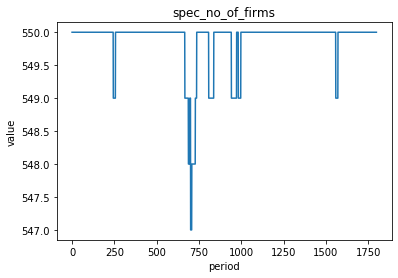

In [382]:
plot(TSs[tss[i]].sums(), title = tss[i])
i +=1

# Final data

In [25]:
def periodize(series, cumulation = False, perioda = 12):
    """Decreases frequency of the data or accumulates over given period."""
    results = []
    for country in series:
        if cumulation:
            res = [sum(country[i:(i+perioda)]) for i in range(0,len(country),perioda)]
            results.append(res)
        else:
            results.append(country[::perioda])
    return results

In [66]:
mean_yearly_income = periodize(TSs["hsh_income"].means(), True) 

In [277]:
yearly_inv = periodize(TSs["inventories"].sums(), False)

In [26]:
def growths(series, rate = True):
    """Returns time series of growth or growth rates."""
    results = []
    for country in series:
        s1 = np.array(country[:-1])    # t-1
        s2 = np.array(country[1:])     # t
        diff = s2 - s1
        if rate:
            results.append(list(diff/s1))
        else:
            results.append(list(diff))
    return results

In [27]:
def differences(series1, series2, relative = True):
    """Returns simple or relative differences of two sets of time series."""
    results = []
    for country_s1, country_s2 in zip(series1, series2):   # iterate over countries
        incon = len(country_s1) - len(country_s2)     # if we compare growth series with normal one there is difference in length
        if incon == 0:
            s1, s2 = np.array(country_s1), np.array(country_s2)
        else:
            s1, s2 = (np.array(country_s1[1:]), np.array(country_s2)) if incon > 0 else (np.array(country_s1), np.array(country_s2[1:]))
        diff = s1 - s2
        if relative:
            results.append(list(diff/s1))
        else: 
            results.append(list(diff))
    return results

In [250]:
left_owers = differences(TSs["production"].sums(), TSs["sales"].sums(), False)
new_inventories = growths(TSs["inventories"].sums(), False) 
liqiudations = differences(left_owers, new_inventories, False)

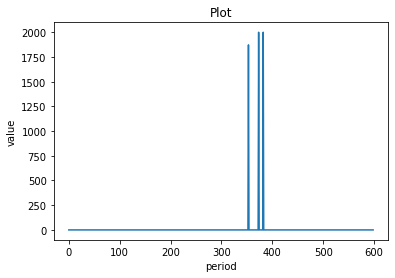

In [251]:
plot(liqiudations)

In [28]:
def ratios(series1, series2):
    """Returns ratios of two sets of time series"""
    results = []
    for country_s1, country_s2 in zip(series1, series2):   # iterate over countries
##        incon = len(country_s1) - len(country_s2)     # if we compare growth series with normal one there is difference in length
##        if incon == 0:
        s1, s2 = np.array(country_s1), np.array(country_s2)
##        else:
##            s1, s2 = (np.array(country_s1[1:]), np.array(country_s2)) if incon > 0 else (np.array(country_s1), np.array(country_s2[1:]))
        results.append(list(s1/s2))
    return results

In [248]:
wages_to_income = ratios(TSs["wages"].sums(), TSs["hsh_income"].sums()  )

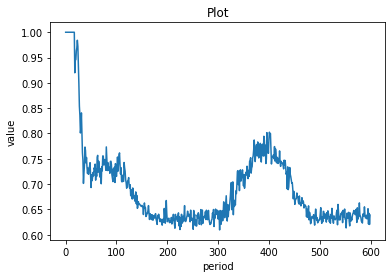

In [249]:
plot(wages_to_income)

# Visualization

In [31]:
import matplotlib.pyplot as plt

In [23]:
class Visual:
    
    def plot(series, y_label = "value", title = "Plot", zipping = True):
        if zipping:
            ys = list(zip(*series))
        else:
            ys = series
        plt.plot(ys) 
        plt.ylabel(y_label)
        plt.xlabel("period")         # months or years
        plt.title(title)
        plt.show()
        

In [24]:
plot = Visual.plot

# 1-country replication results

up:     extreme alternative with wage_resist = 8, wage_flex = 0.25

middle: alternative with wage_resist = 8, wage_flex = 0.08

down:   baseline wage_resist = 12, wage_flex = 0.05

In [37]:
price_stats = [TSs["prices"].mins()[0], TSs["prices"].medians()[0], TSs["prices"].maxs()[0]]

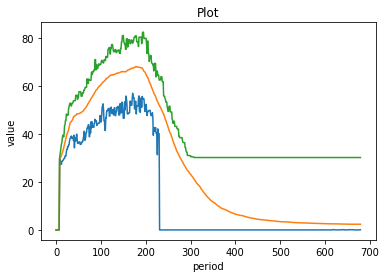

In [38]:
plot(price_stats)

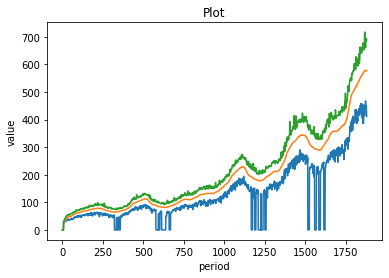

In [462]:
plot(price_stats)   #

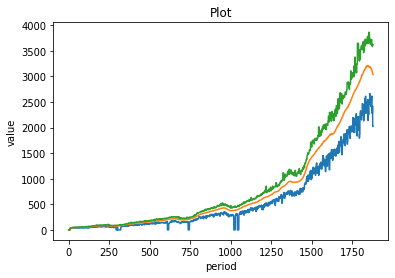

In [398]:
plot(price_stats)           ####

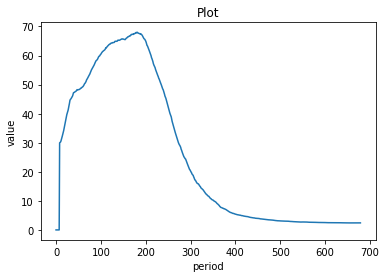

In [39]:
plot(TSs["prices"].means())

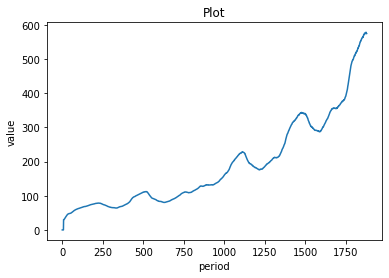

In [463]:
plot(TSs["prices"].means())   #

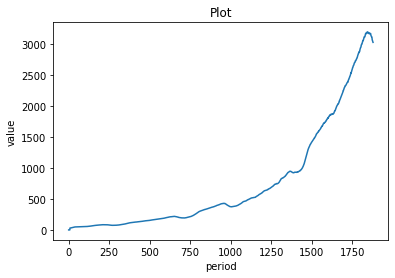

In [399]:
plot(TSs["prices"].means())           ####

In [40]:
wage_stats = [TSs["working_wages"].mins()[0], TSs["working_wages"].medians()[0], TSs["working_wages"].maxs()[0]]

In [504]:
TSs["working_wages"].means()[0][-14:]  # 1800 periods

[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]

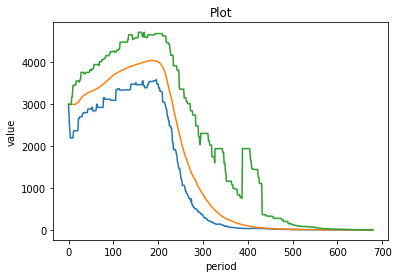

In [41]:
plot(wage_stats)

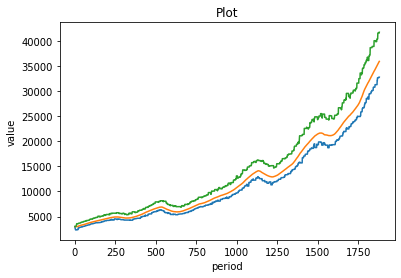

In [465]:
plot(wage_stats)   #

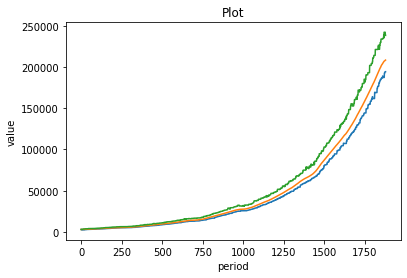

In [401]:
plot(wage_stats)           ####

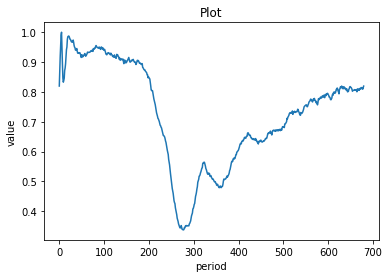

In [42]:
plot(TSs["employment"].means())

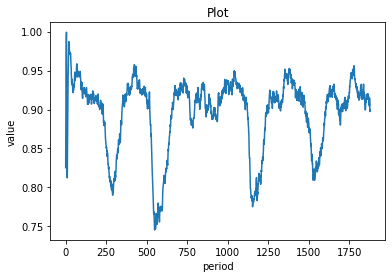

In [466]:
plot(TSs["employment"].means())   #

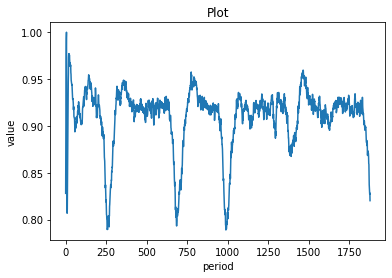

In [402]:
plot(TSs["employment"].means())           ####

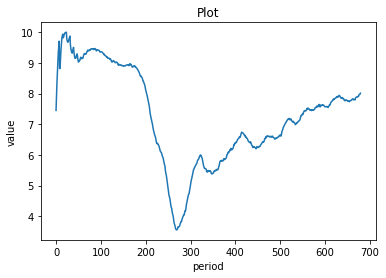

In [43]:
plot(TSs["labor_demand"].means())

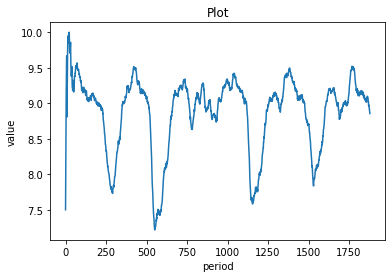

In [467]:
plot(TSs["labor_demand"].means())   #

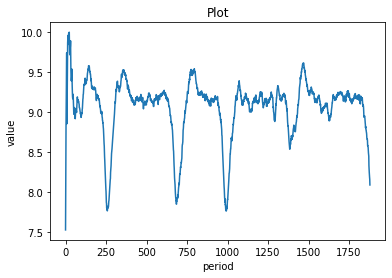

In [403]:
plot(TSs["labor_demand"].means())           ####

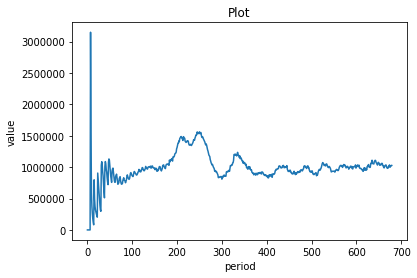

In [44]:
plot(TSs["inventories"].sums()) 

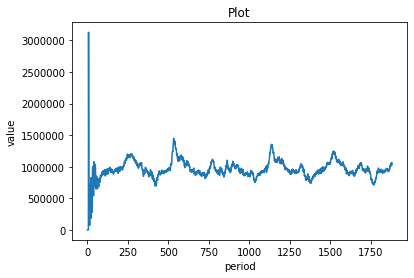

In [468]:
plot(TSs["inventories"].sums())    #

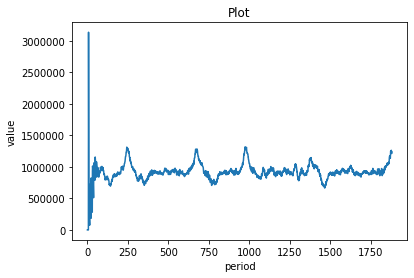

In [404]:
plot(TSs["inventories"].sums())            ####

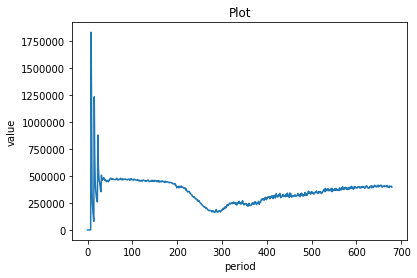

In [45]:
plot(TSs["sales"].sums())

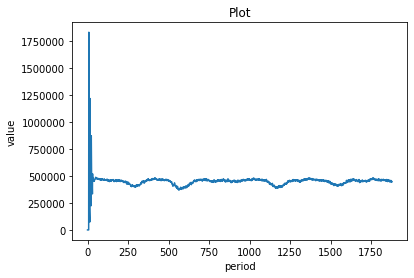

In [469]:
plot(TSs["sales"].sums())   #

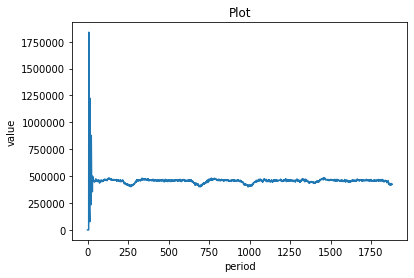

In [405]:
plot(TSs["sales"].sums())           ####

In [509]:
TSs["sales_value"].sums()[0][-15:]   # 1800 periods

[509478,
 500113,
 485365,
 493566,
 497886,
 496442,
 499925,
 504228,
 490251,
 496278,
 495446,
 495043,
 498567,
 501738,
 499426]

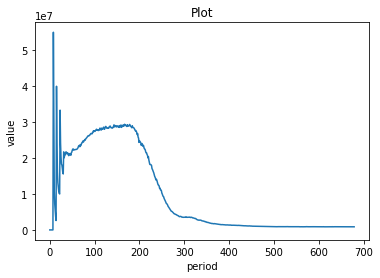

In [46]:
plot(TSs["sales_value"].sums())

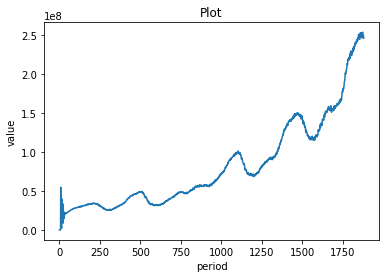

In [470]:
plot(TSs["sales_value"].sums())   #

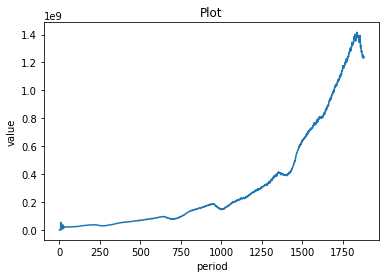

In [406]:
plot(TSs["sales_value"].sums())           ####

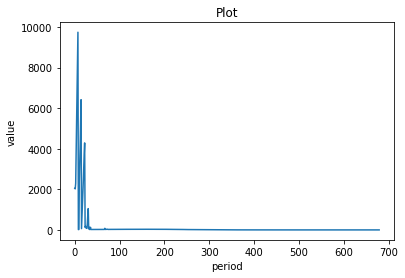

In [47]:
plot(TSs["forced_savings"].means())

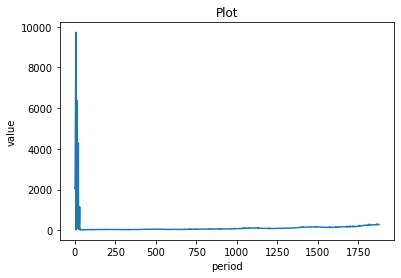

In [471]:
plot(TSs["forced_savings"].means())   #

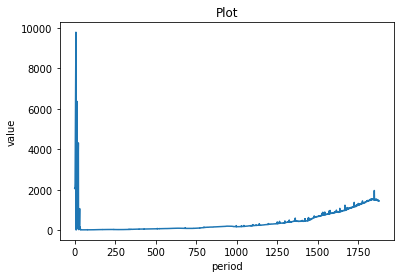

In [407]:
plot(TSs["forced_savings"].means())           ####

In [517]:
TSs["hsh_deposits"].sums()[0][-9:]   # 1800 periods

[859330, 861700, 859066, 857917, 857791, 865721, 859212, 855881, 862419]

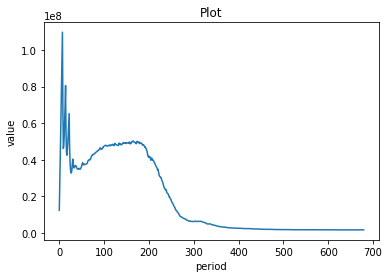

In [48]:
plot(TSs["hsh_deposits"].sums())

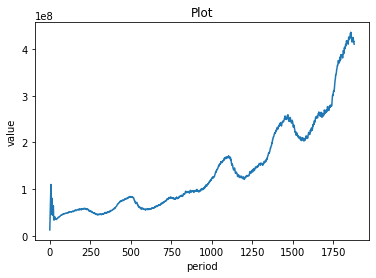

In [472]:
plot(TSs["hsh_deposits"].sums())   #

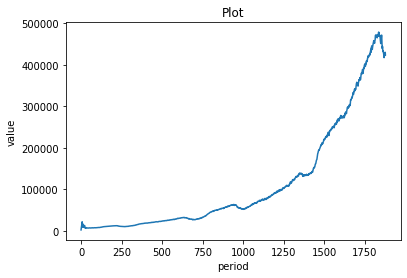

In [409]:
plot(TSs["hsh_deposits"].means())           ####

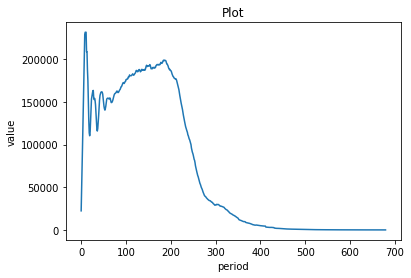

In [49]:
plot(TSs["loans"].means())

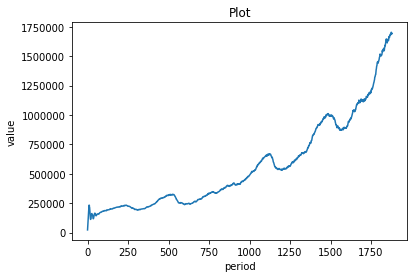

In [473]:
plot(TSs["loans"].means())   #

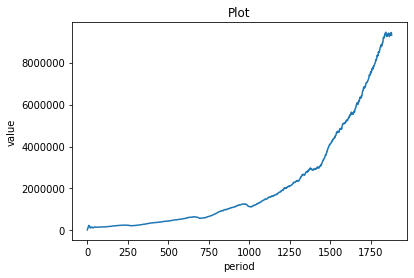

In [410]:
plot(TSs["loans"].means())           ####

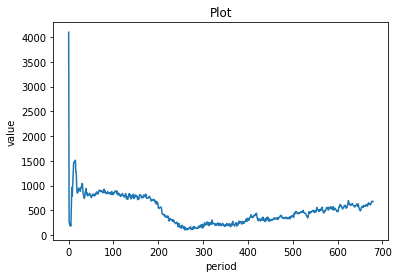

In [50]:
plot(TSs["job_offers"].sums())

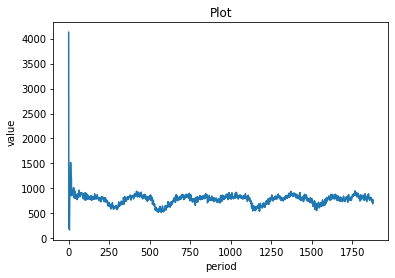

In [474]:
plot(TSs["job_offers"].sums())   #

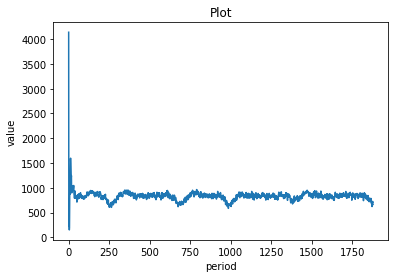

In [411]:
plot(TSs["job_offers"].sums())           ####

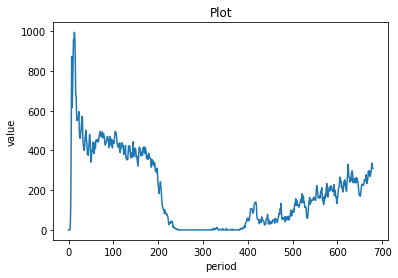

In [51]:
plot(TSs["vacancies"].sums())

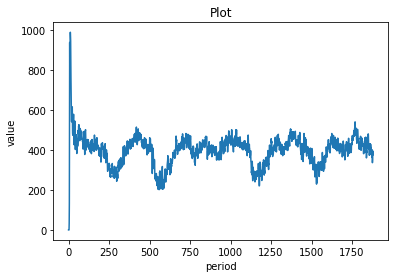

In [475]:
plot(TSs["vacancies"].sums())   #

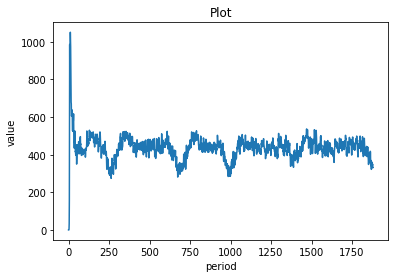

In [412]:
plot(TSs["vacancies"].sums())           ####

In [523]:
TSs["firm_dividends"].means()[0][-10:]   # 1800 periods

[882.93, 884.28, 889.96, 855.62, 869.27, 869.73, 883.42, 863.6, 875.17, 889.12]

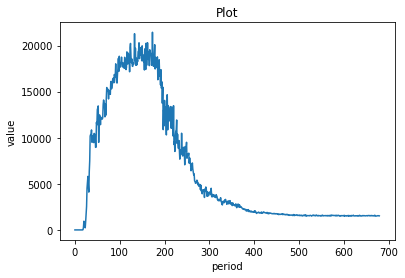

In [52]:
plot(TSs["firm_dividends"].means())

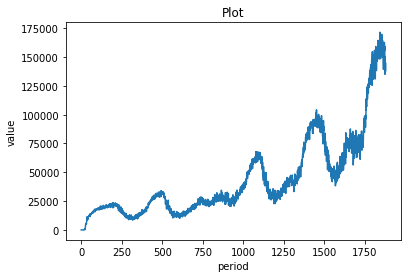

In [476]:
plot(TSs["firm_dividends"].means())   #

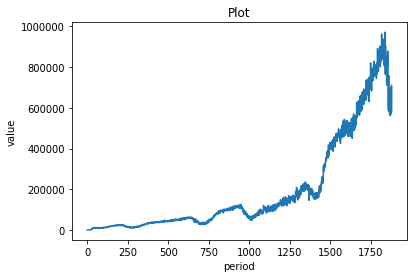

In [413]:
plot(TSs["firm_dividends"].means())           ####

In [524]:
TSs["bank_dividend"].sums()[0][-10:]   # 1800 periods

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

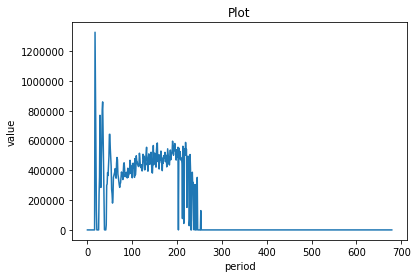

In [53]:
plot(TSs["bank_dividend"].sums())

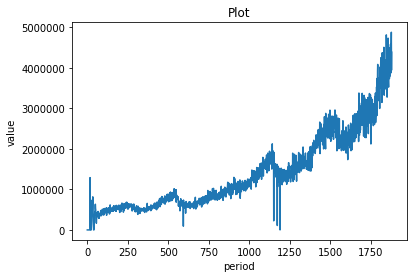

In [477]:
plot(TSs["bank_dividend"].sums())   #

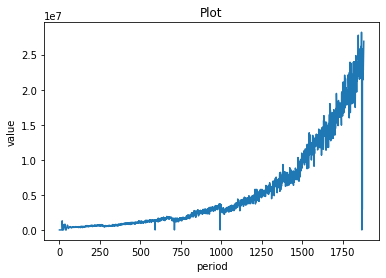

In [414]:
plot(TSs["bank_dividend"].sums())           ####

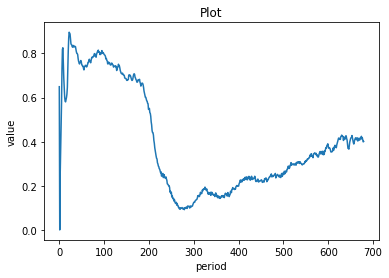

In [54]:
plot(TSs["hsh_sentiment"].means())

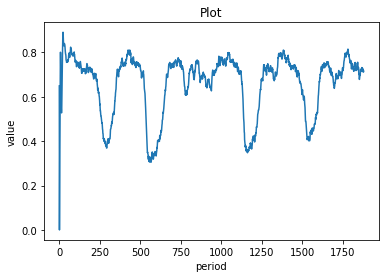

In [478]:
plot(TSs["hsh_sentiment"].means())   #

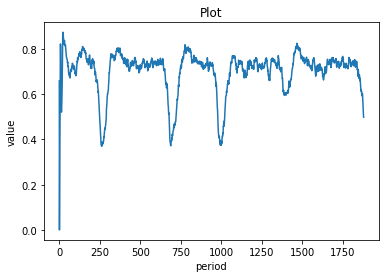

In [415]:
plot(TSs["hsh_sentiment"].means())           ####

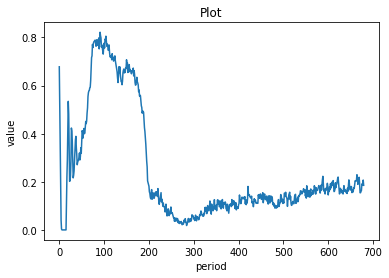

In [55]:
plot(TSs["firm_sentiment"].means())

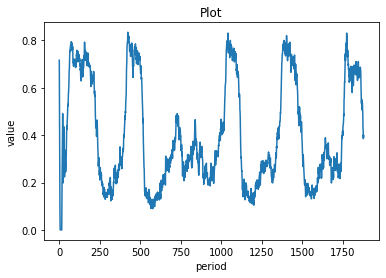

In [479]:
plot(TSs["firm_sentiment"].means())   #

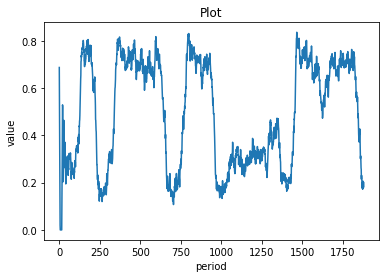

In [416]:
plot(TSs["firm_sentiment"].means())           ####

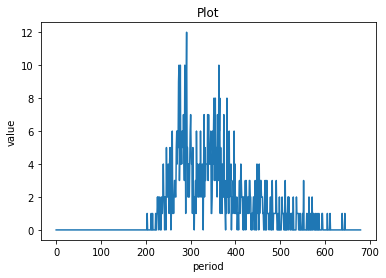

In [56]:
plot(TSs["bankruptcies"].sums())

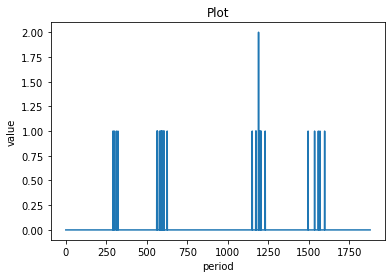

In [480]:
plot(TSs["bankruptcies"].sums())   #

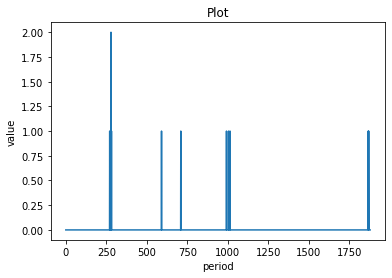

In [417]:
plot(TSs["bankruptcies"].sums())           ####

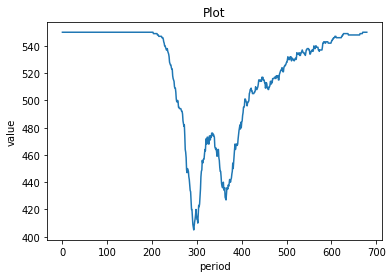

In [57]:
plot(TSs["spec_no_of_firms"].sums())

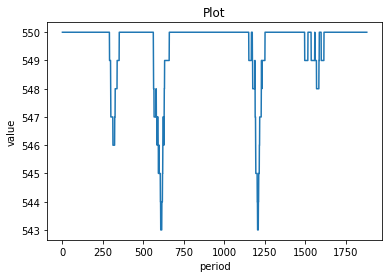

In [481]:
plot(TSs["spec_no_of_firms"].sums())   #

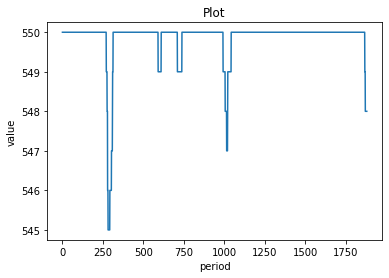

In [418]:
plot(TSs["spec_no_of_firms"].sums())           #### 

In [534]:
TSs["doubtful_ratio"].sums()[0][-6:]   # 1800 periods

[-138.2700715805765,
 -136.23775734982632,
 -135.6029724886687,
 -133.7723501154158,
 -134.0168128502677,
 -134.95229303906348]

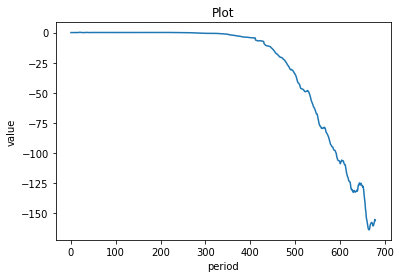

In [58]:
plot(TSs["doubtful_ratio"].sums()) 

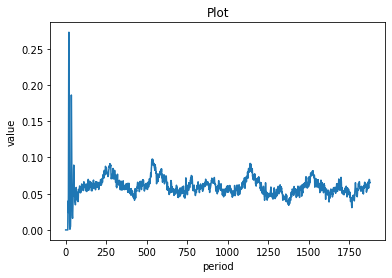

In [482]:
plot(TSs["doubtful_ratio"].sums())     #

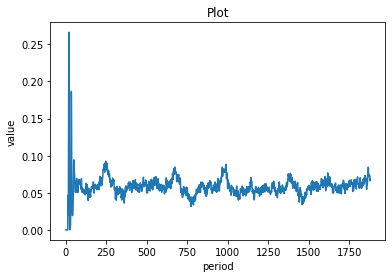

In [420]:
plot(TSs["doubtful_ratio"].sums())           #### 

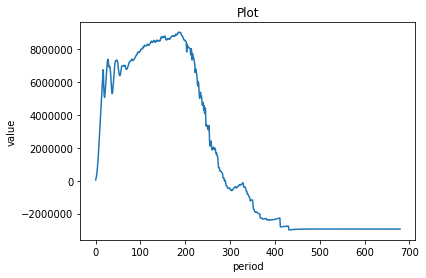

In [59]:
plot(TSs["bank_capital"].sums()) 

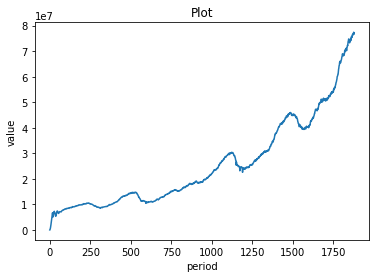

In [483]:
plot(TSs["bank_capital"].sums())     # 

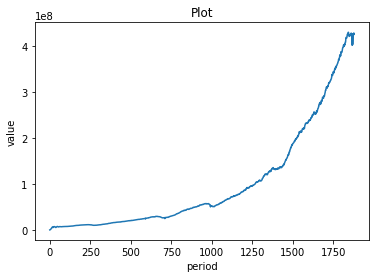

In [421]:
plot(TSs["bank_capital"].sums())           #### 

In [419]:
TSs

{'employment': <__main__.TS at 0x150b96f8390>,
 'wages': <__main__.TS at 0x150b9897ac8>,
 'working_wages': <__main__.TS at 0x150b9897b38>,
 'vol_unemployed': <__main__.TS at 0x150b9897ba8>,
 'months_u': <__main__.TS at 0x150b9897be0>,
 'hsh_sentiment': <__main__.TS at 0x150b9897c18>,
 'hsh_income': <__main__.TS at 0x150b9897c50>,
 'savings_T': <__main__.TS at 0x150b9897c88>,
 'cons': <__main__.TS at 0x150b9897cc0>,
 'cons_value': <__main__.TS at 0x150b9897d30>,
 'forced_savings': <__main__.TS at 0x150b9897d68>,
 'hsh_deposits': <__main__.TS at 0x150b9897da0>,
 'prices': <__main__.TS at 0x150b9897dd8>,
 'offered_wages': <__main__.TS at 0x150b9897e10>,
 'production': <__main__.TS at 0x150b9897e80>,
 'production_value': <__main__.TS at 0x150b9897eb8>,
 'labor_demand': <__main__.TS at 0x150b9897ef0>,
 'job_offers': <__main__.TS at 0x150b9897f28>,
 'vacancies': <__main__.TS at 0x150b9897f60>,
 'inventories': <__main__.TS at 0x150b9897f98>,
 'sales': <__main__.TS at 0x150b989d048>,
 'sales_v

In [50]:
chosen_HSHs[0].archive

['archive of 0_h_0',
 ('wage', 'res_wage', 'employed', 'cons', 'forced_savings'),
 ['period: 0', 3000, 0, True, 0, 2400],
 ['period: 1', 3000, 3000, True, 0, 2400],
 ['period: 2', 3000, 3000, True, 0, 2400],
 ['period: 3', 3000, 3000, True, 0, 4800],
 ['period: 4', 3000, 3000, True, 0, 5400],
 ('wage', 'res_wage', 'employed', 'cons', 'forced_savings'),
 ['period: 5', 3000, 3000, True, 0, 7800],
 ['period: 6', 3000, 3000, True, 0, 9300],
 ['period: 7', 3000, 3000, True, 0, 10800],
 ['period: 8', 3000, 3000, True, 410, 4],
 ['period: 9', 3000, 3000, True, 258, 13],
 ('wage', 'res_wage', 'employed', 'cons', 'forced_savings'),
 ['period: 10', 3000, 3000, True, 0, 5332],
 ['period: 11', 0, 3000, False, 0, 5432],
 ['period: 12', 3220, 3000, True, 207, 13],
 ['period: 13', 3220, 3220, True, 0, 4706],
 ['period: 14', 3220, 3220, True, 0, 7145],
 ('wage', 'res_wage', 'employed', 'cons', 'forced_savings'),
 ['period: 15', 3220, 3220, True, 221, 8],
 ['period: 16', 3220, 3220, True, 186, 33],
 ['